# 2D variables: MLD, SI, surface fluxes

In [ ]:
# Not needed for B-SOSE

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session

import s3fs

In [ ]:
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests

import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import numpy as np
import pandas as pd
import calendar
import gsw
#import warnings

In [ ]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42155")
client.ncores
client.restart()

In [55]:
# Plotting settings

plt.rcParams['figure.figsize'] = (10, 3)

In [105]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first 20 files
print('\nFirst 20 files')
pprint([x.name for x in bsose_files[:20]])


First 20 files
['ADVrDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'ADVxDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVyDIC_bsoseI156_2013to2024_monthly.nc',
 'DIC_bsoseI156_2013to2024_monthly.nc',
 'Fe_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'NO3_bsoseI156_2013to2024_monthly.nc',
 'NPP_bsoseI156_2013to2024_monthly.nc',
 'SIArea_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc',
 'Theta_bsoseI156_2013to2024_monthly.nc',
 'WVELSLT_bsoseI156_2013to2024_monthly.nc',
 'WVELTH_bsoseI156_2013to2024_monthly.nc',
 'Wvel_bsoseI156_2013to2024_monthly.nc',
 'grid.nc',
 'oceQnet_bsoseI156_2013to2024_monthly.nc',
 'oceSflux_bsoseI156_2013to2024_monthly.nc',
 'surfCO2flx_bsoseI156_2013to2024_monthly.nc']


In [106]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# open dataset
MLD_file = bsose_path / 'MLD_bsoseI156_2013to2024_monthly.nc'
SI_file = bsose_path / 'SIArea_bsoseI156_2013to2024_monthly.nc'
surfSflx_file = bsose_path / 'surfSflx_bsoseI156_2013to2024_monthly.nc'
surfTflx_file = bsose_path / 'surfTflx_bsoseI156_2013to2024_monthly.nc'
surfCO2flx_file = bsose_path / 'surfCO2flx_bsoseI156_2013to2024_monthly.nc'
oceSflux_file = bsose_path / 'oceSflux_bsoseI156_2013to2024_monthly.nc'
oceQnet_file = bsose_path / 'oceQnet_bsoseI156_2013to2024_monthly.nc'
grid_file = bsose_path / 'grid.nc'

In [107]:
# load the file into memory (note 'load' command at the end)
grid_ds = xr.open_dataset(grid_file).load()
MLD_ds = xr.open_dataset(MLD_file).load()
SI_ds = xr.open_dataset(SI_file).load()
surfTflx_ds = xr.open_dataset(surfTflx_file).load()
surfSflx_ds = xr.open_dataset(surfSflx_file).load()
surfCO2flx_ds = xr.open_dataset(surfCO2flx_file).load()
oceSflux_ds = xr.open_dataset(oceSflux_file).load()
oceQnet_ds = xr.open_dataset(oceQnet_file).load()

# show contents of single granule
MLD_ds

<xarray.Dataset> Size: 753MB
Dimensions:  (time: 144, XC: 2160, YC: 588)
Coordinates:
    iter     (time) int64 1kB 4380 6570 8760 10950 ... 313170 315360 317550
  * time     (time) datetime64[ns] 1kB 2013-01-30T20:00:00 ... 2024-12-28T10:...
  * XC       (XC) float32 9kB 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC       (YC) float32 2kB -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
    rA       (YC, XC) float32 5MB 1.488e+07 1.488e+07 ... 2.921e+08 2.921e+08
    Depth    (YC, XC) float32 5MB 0.0 0.0 0.0 0.0 ... 4.8e+03 4.8e+03 4.737e+03
    maskInC  (YC, XC) bool 1MB False False False False ... True True True True
    rSurfC   (YC, XC) float32 5MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rLowC    (YC, XC) float32 5MB 0.0 0.0 0.0 ... -4.8e+03 -4.8e+03 -4.737e+03
Data variables:
    BLGMLD   (time, YC, XC) float32 732MB 4.2 4.2 4.2 4.2 ... 7.42 7.521 7.736

In [113]:
# Load variables
MLD = MLD_ds['BLGMLD']
TFLUX = surfTflx_ds['TFLUX']
SFLUX = surfSflx_ds['SFLUX']
CO2FLUX = surfCO2flx_ds['BLGCFLX']
oceQnet = oceQnet_ds['oceQnet']
oceSflux = oceSflux_ds['oceSflux']
SI = SI_ds['SIarea']
maskInC = MLD_ds['maskInC']

time = MLD_ds['time']
XC = grid_ds['XC']
YC = grid_ds['YC']

In [114]:
MLD_masked = MLD.where(maskInC==True,np.nan)
TFLUX_masked = TFLUX.where(maskInC==True,np.nan)
SFLUX_masked = SFLUX.where(maskInC==True,np.nan)
CO2FLUX_masked = CO2FLUX.where(maskInC==True,np.nan)
oceSflux_masked = oceSflux.where(maskInC==True,np.nan)
oceQnet_masked = oceQnet.where(maskInC==True,np.nan)
SI_masked = SI.where(maskInC==True,np.nan)

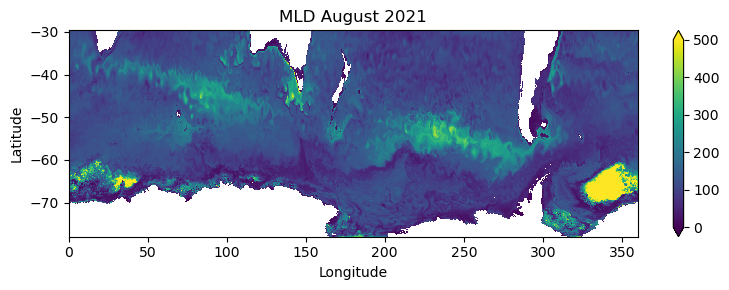

In [58]:
plt.figure(figsize=(8, 3))

#ti=97 # feb 2021
ti=103 # aug 2021
var = MLD_masked[ti,:,:]

time_str = pd.to_datetime(MLD_ds.time[ti].values).strftime('%B %Y')

vmin=0
vmax=500
plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='viridis')
#plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, shading='auto', cmap='viridis')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'MLD {time_str}')
plt.tight_layout()

#plt.savefig(f"figures_anna/MLD_map_aug2021.png", dpi=300, bbox_inches='tight')

plt.show()

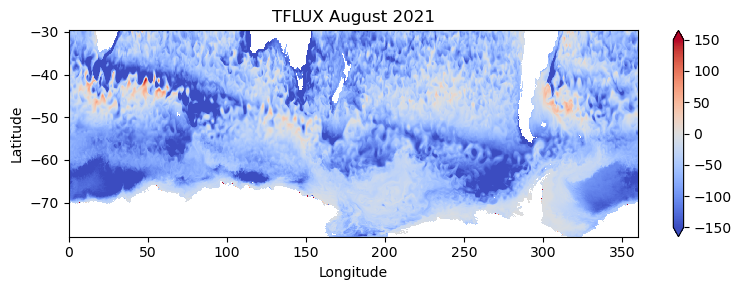

In [75]:
plt.figure(figsize=(8, 3))

#ti=97 # feb 2021
ti=103 # aug 2021
var = TFLUX_masked[ti,:,:]

time_str = pd.to_datetime(MLD_ds.time[ti].values).strftime('%B %Y')

vmin=-150
vmax=150
plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='coolwarm')
#plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, shading='auto', cmap='coolwarm')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'TFLUX {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/TFLUX_map_aug2021.png", dpi=300, bbox_inches='tight')

plt.show()

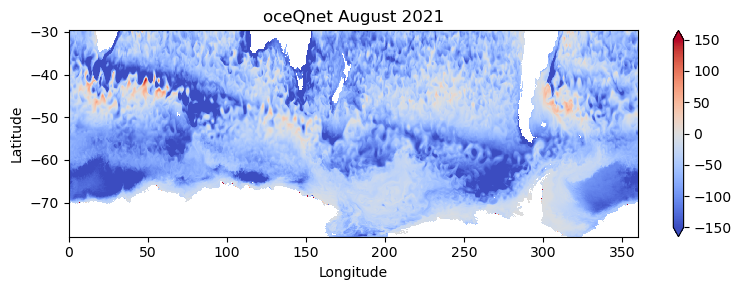

In [118]:
plt.figure(figsize=(8, 3))

#ti=97 # feb 2021
ti=103 # aug 2021
var = oceQnet_masked[ti,:,:]

time_str = pd.to_datetime(MLD_ds.time[ti].values).strftime('%B %Y')

vmin=-150
vmax=150
plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='coolwarm')
#plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, shading='auto', cmap='coolwarm')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'oceQnet {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/oceQnet_map_aug2021.png", dpi=300, bbox_inches='tight')

plt.show()

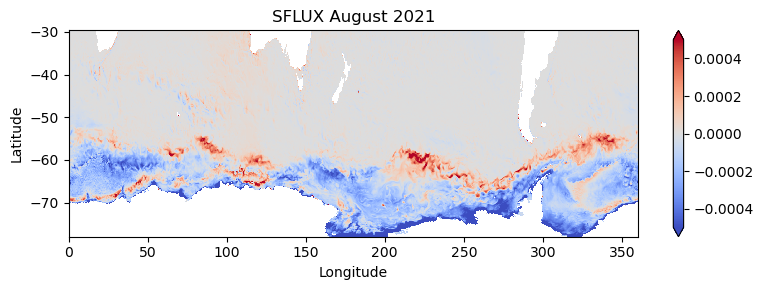

In [93]:
plt.figure(figsize=(8, 3))

#ti=97 # feb 2021
ti=103 # aug 2021
var = SFLUX_masked[ti,:,:]

time_str = pd.to_datetime(MLD_ds.time[ti].values).strftime('%B %Y')

vmin=-5e-4
vmax=5e-4
plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='coolwarm')
#plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, shading='auto', cmap='BrBG')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'SFLUX {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/SFLUX_map_aug2021.png", dpi=300, bbox_inches='tight')

plt.show()

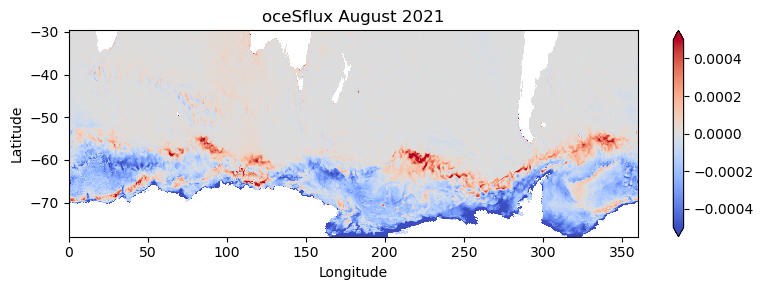

In [119]:
plt.figure(figsize=(8, 3))

#ti=97 # feb 2021
ti=103 # aug 2021
var = oceSflux_masked[ti,:,:]

time_str = pd.to_datetime(MLD_ds.time[ti].values).strftime('%B %Y')

vmin=-5e-4
vmax=5e-4
plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='coolwarm')
#plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, shading='auto', cmap='BrBG')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'oceSflux {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/oceSflux_map_aug2021.png", dpi=300, bbox_inches='tight')

plt.show()

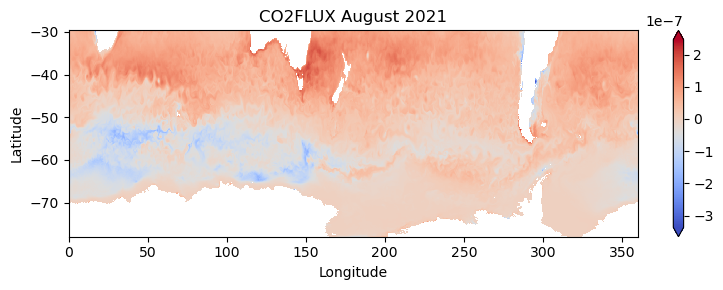

In [94]:
plt.figure(figsize=(8, 3))

#ti=97 # feb 2021
ti=103 # aug 2021
var = CO2FLUX_masked[ti,:,:]

time_str = pd.to_datetime(MLD_ds.time[ti].values).strftime('%B %Y')

vmin=0
vmax=500
#plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='viridis')
plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, shading='auto', cmap='coolwarm')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'CO2FLUX {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/CO2FLUX_map_aug2021.png", dpi=300, bbox_inches='tight')

plt.show()

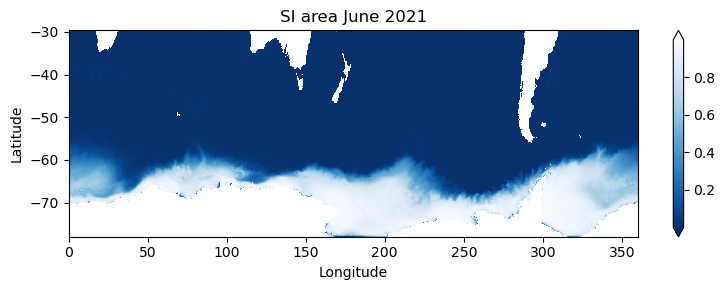

In [125]:
plt.figure(figsize=(8, 3))

#ti=97 # feb 2021
ti=101 # aug 2021
var = SI_masked[ti,:,:]

time_str = pd.to_datetime(MLD_ds.time[ti].values).strftime('%B %Y')

vmin=0
vmax=500
#plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='viridis')
plt.pcolormesh(MLD_ds.XC, MLD_ds.YC, var, shading='auto', cmap='Blues_r')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'SI area {time_str}')
plt.tight_layout()

plt.savefig(f"figures_anna/SIarea_map_jun2021.png", dpi=300, bbox_inches='tight')

plt.show()